Tristan MANIER - Léa GRASSIEN - Mathieu RAMEL - INFO 5 - 9/01/2024


# 1. Présentation des données

Pourquoi avons nous choisis ces données ?
TODO

source, conditions de recueil, nombre de fichiers, nombres de variables et d'individus, expliquer l'activité derrière les données.
TODO
Notre dataset contient deux fichiers : eCO2mix_RTE_En-cours-TR.csv, donnees-synop-essentielles-omm.csv 
Le fichier eCO2mix_RTE_En-cours-TR.csv contient les données de consommation et de production en électricité en France, les échanges d'éléctricité avec d'autres pays Européens sur une période allant de juin 2022 à fin 2023.
Le fichier donnees-synop-essentielles-omm.csv contient les données météorologiques de la France sur les années 2022 à 2023.

Donnez la signification desindividus et des variables
TODO

## Questions

### Analyse
Nous allons chercher à répondre à ces questions :
- Quelles sont les sources de production d'énergie les plus corrélées ?
- Quelles est la proportion d'énergie renouvelable produite ?
- Quelles sont les tendances de méthode de production d'énergie au cours de l'année ?
- Quelles sont les périodes de l'année où la production d'énergie est la plus importante/faible ?
- Quelles sont les moments de la journée où la production d'énergie est la plus importante/faible ?
- La météo influe-t-elle sur la consomation d'énergie ?
- Quelles sont les sources de production d'énergie les plus corrélées avec la météo ?
- Classification des jousrsde l'année par rapport à la consomation d'énergie.

### Prédictions
- Quelle est la tendance de production d'énergie pour les jours/mois/années à venir ?

Aprrentissage supervisé ET non supervisé

# 2. Préparation des données

Ce notebook présente les commandes utiles pour les principales tâches de préparation des données. Les données `notes.data` qui servent d'illustration sont des notes obtenues par des étudiants dans des matières.

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 100)     # Set the maximum number of rows displayed to 100 rows

import math

## 2.1 Premier dataset sur la production d'énergie

In [35]:
file_name = "eCO2mix_RTE_En-cours-TR.csv"

df = pd.read_csv(file_name, sep="\t", encoding='latin-1', index_col=False)

df.head()

C:\Users\tmani\AppData\Local\Temp\ipykernel_14448\1020470220.py:3: DtypeWarning: Columns (5,26,27,30,31,33,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, sep="\t", encoding='latin-1', index_col=False)


,Périmètre,Nature,Date,Heures,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,...,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz,Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore
0,France,Données temps réel,2022-06-01,00:00,44940.0,44800,45100.0,144.0,0.0,3596.0,...,4331,1054,1677.0,170,584.0,286.0,ND,ND,ND,ND
1,France,Données temps réel,2022-06-01,00:15,43967.0,43700,43900.0,144.0,0.0,3716.0,...,4163,1419,581.0,171,560.0,276.0,ND,ND,ND,ND
2,France,Données temps réel,2022-06-01,00:30,42514.0,42600,42700.0,142.0,0.0,2880.0,...,4187,1280,530.0,169,561.0,276.0,ND,ND,ND,ND
3,France,Données temps réel,2022-06-01,00:45,41073.0,41450,41600.0,143.0,0.0,2699.0,...,4054,1120,361.0,170,563.0,276.0,ND,ND,ND,ND
4,France,Données temps réel,2022-06-01,01:00,40359.0,40300,40500.0,144.0,3.0,2718.0,...,4068,1101,373.0,170,563.0,276.0,ND,ND,ND,ND


Renommage des colonnes pour retirer les espaces et faciliter la selection ensuite

In [ ]:
df.columns = [c.replace(' ', '_') for c in df.columns]
df.head()

Affichage des données non-définies

In [ ]:
temp = ({
    'column':[],
    'type':[],
    'nb_lines' :[],
    'nb_ND':[]
})

nd = pd.DataFrame(temp)

for column in df.columns : 

    new_row = pd.DataFrame({'column': column, 'type': df[column].dtype, 'nb_lines': df[column].count(), 'nb_ND': (df[column] == 'ND').sum()}, index=[0])
    nd = pd.concat([new_row, nd.loc[:]]).reset_index(drop=True)
nd = nd.sort_values(by='nb_ND', ascending=False)

nd["%ND"] = nd["nb_ND"] / nd["nb_lines"] * 100

nd

Type de la date incorrect

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])

Suppression des lignes sans information de consommation et sans prédiction 

In [38]:
df = df[df['Prévision_J-1'] != 'ND']
df = df[:-1]

Hydrolique est décomposé en 3 catégories : 'Hydraulique - Fil de l?eau + éclusée', 'Hydraulique - Lacs', 'Hydraulique - STEP turbinage' \
Bioénergies est décomposé en 3 catégories : 'Bioénergies - Déchets', 'Bioénergies - Biomasse', 'Bioénergies - Biogaz' \
Eolien est décomposé en 2 catégories : 'Eolien terrestre', 'Eolien offshore' \
Fioul est décomposé en 3 catégories : 'Fioul - TAC', 'Fioul - Cogén.', 'Fioul - Autres' \
Gaz est décomposé en 3 catégories :  'Gaz - TAC', 'Gaz - Cogén.', 'Gaz - CCG', 'Gaz - Autres' 

Les deux colonnes sur les batteries ne semble pas pertinente non plus.

In [39]:
list_energy = ['Périmètre', 'Date', 'Heures', 'Consommation',
       'Prévision_J-1', 'Prévision_J', 'Fioul', 'Charbon', 'Gaz', 'Nucléaire',
       'Eolien', 'Solaire', 'Hydraulique', 'Pompage', 'Bioénergies',
       'Ech._physiques', 'Taux_de_Co2', 'Ech._comm._Angleterre',
       'Ech._comm._Espagne', 'Ech._comm._Italie', 'Ech._comm._Suisse',
       'Ech._comm._Allemagne-Belgique']

for col_name in df.columns:
    if col_name not in list_energy:

        df = df.drop(col_name, axis=1)

In [40]:
columns_to_sum = ['Fioul', 'Charbon', 'Gaz', 'Nucléaire', 'Eolien', 'Solaire', 'Hydraulique', 'Pompage', 'Bioénergies']
df ['Production'] = df[columns_to_sum].sum(axis=1)

In [41]:
print(f"{df.shape[0]} rows and {df.shape[1]} columns")

# Combine dtypre, count and nnunique
pd.concat([df.dtypes, df.count(), df.nunique()], keys=["Types", "Count", "NUnique"], axis=1)

56545 rows and 23 columns


,Types,Count,NUnique
Périmètre,object,56545,1
Date,object,56545,590
Heures,object,56545,96
Consommation,float64,56398,28441
Prévision_J-1,object,56545,2153
Prévision_J,float64,56448,2038
Fioul,float64,56398,1154
Charbon,float64,56398,1607
Gaz,float64,56398,8857
Nucléaire,float64,56398,21598


Ici on observe que les types des colonnes restantes sont plus logiques, on obtient plus de float au lieu de type object sur des colonnes decrivant une consommation ou une production.

### Statistiques descriptives des valeurs non-définies

In [ ]:
df_full.head()

# 3. Analyse des données

Selection d'une periode de temps

In [ ]:
from matplotlib import pyplot as plt

#select rows between date1 and date 2
date1 = pd.to_datetime('2022-06-01')
date2 = pd.to_datetime('2023-12-01')

df_selection = df_full[(df_full['date'] >= date1) & (df_full['date'] < date2)]

## La période a-t-elle une influence sur la production et la consommation ?

Visualisation des données de consomations

In [ ]:
figure = plt.figure(figsize=(20,10))
plt.plot(df_selection["date"], df_selection["Consommation"], label=column)
plt.legend( loc='upper right', numpoints = 1 )
plt.xlabel('Date')
plt.ylabel('Production (MW)')
plt.show()

Visualisation des données de production

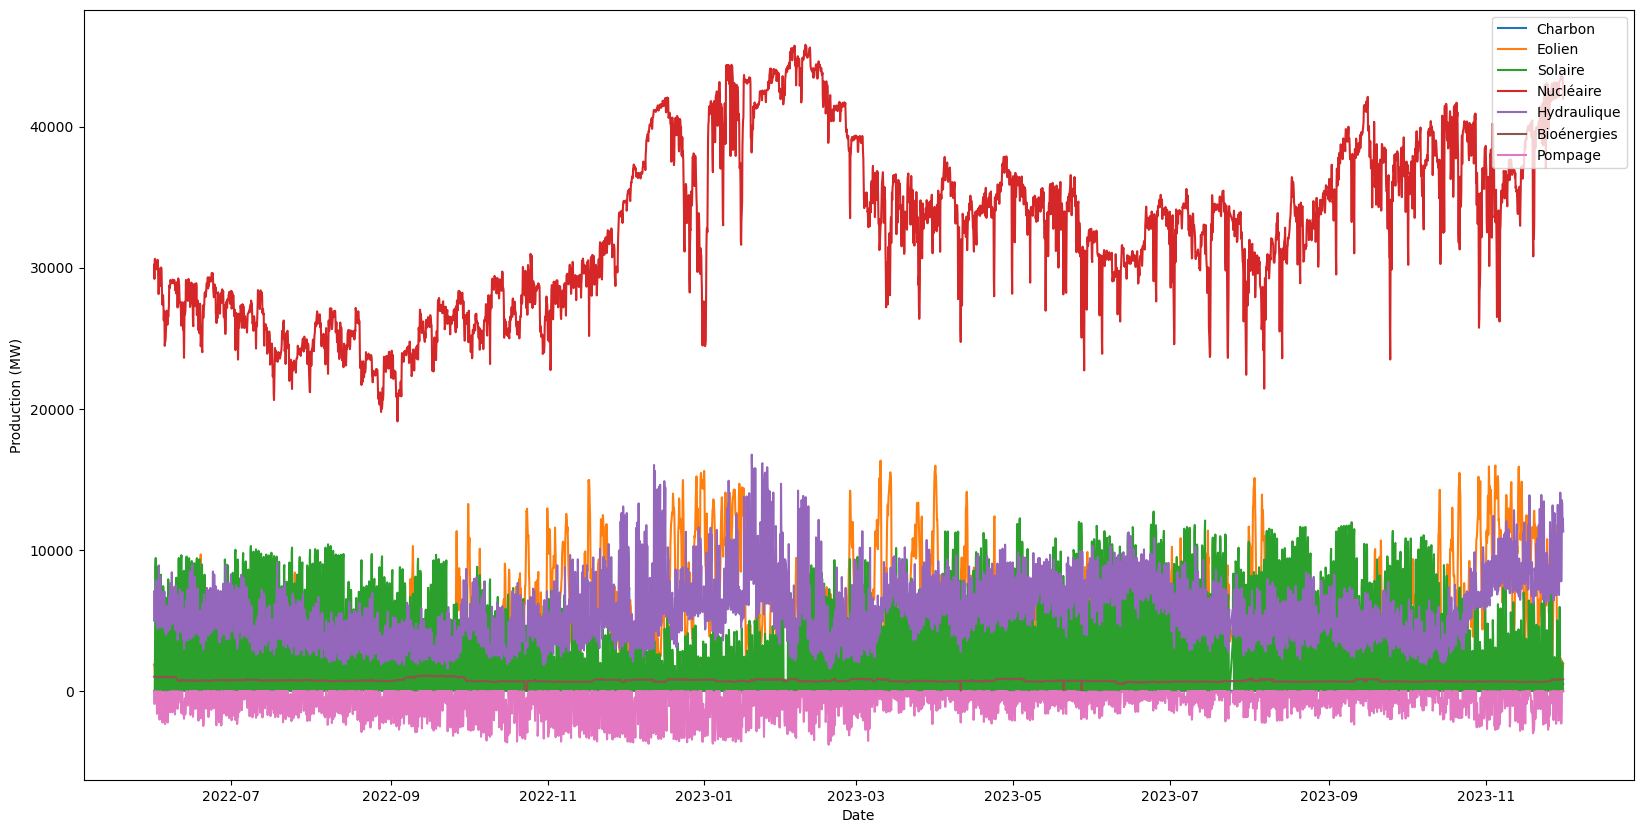

In [ ]:
to_plot = ["Charbon", "Eolien", "Solaire", "Nucléaire", "Hydraulique", "Bioénergies", "Pompage"]

figure = plt.figure(figsize=(20,10))
for column in to_plot :
    plt.plot(df_selection["date"], df_selection[column], label=column)
    plt.legend( loc='upper right', numpoints = 1 )

plt.xlabel('Date')
plt.ylabel('Production (MW)')
plt.show()


In [ ]:
to_plot = ["Consommation", "Production"]

figure = plt.figure(figsize=(20,10))
for column in to_plot :
    plt.plot(df_selection["date"], df_selection[column], label=column)
    plt.legend( loc='upper right', numpoints = 1 )

plt.xlabel('Date')
plt.ylabel('(MW)')
plt.show()

In [ ]:
bin_size = 6

figure = plt.figure(figsize=(20,10))
for i in range(0, 24, bin_size):
    lab = ""
    to_plot = pd.DataFrame()
    for j in range(1, bin_size):
        lab += str(i+j) + ' '
        to_plot = pd.concat([to_plot, df_selection[pd.to_datetime(df_selection["Heures"]).dt.hour == i+j]])
    
    lab += " heures"
    
    plt.plot(to_plot["date"], to_plot['Consommation'], label=lab)
    plt.legend( loc='upper right', numpoints = 1 , title="Interval d'heures")
#plt.plot(df.groupby([ time_date , time_date.dt.hour 'heure']).Consommation.sum())
plt.xlabel('Date')
plt.ylabel('(MW)')
plt.show()



### Quelles sont les sources de production d'énergie les plus corrélées ?

Selections des colonnes liées à la production et description de celles-ci

In [ ]:
df_energies = df_full[["Charbon", "Gaz", "Fioul", "Nucléaire", "Eolien", "Solaire", "Hydraulique", "Bioénergies", "Consommation"]]

df_energies.describe()

Matrice de corrélation

In [ ]:
df_energies.corr()

#### Conclusion
TODO: Mathieu

### Quelles est la proportion d'énergie renouvelable produite ?

Calcul de la production globale d'énergie sur la période du dataset

In [57]:
name_col =["Charbon", "Gaz", "Fioul", "Nucléaire", "Eolien", "Solaire", "Hydraulique", "Bioénergies"]

df_energies = df_full[name_col]

df_energies = df_energies.dropna()

total_energies = sum(df_energies.sum(axis=1))
print(f"Production total : {total_energies} MW")

Production total : 240790057.0 MW


Calcul des proportions de chaque source d'énergie

In [ ]:
sum_dic = {}
pourcent_dic = {}
for col in name_col:
    sum_dic[col] = sum(df_energies[col])
    pourcent_dic[col] = sum_dic[col]/total_energies*100
    
pourcent_df = pd.DataFrame.from_dict(pourcent_dic, orient='index', columns=['%'])
print(pourcent_df)

Aggrégation des sources d'énergie en 3 catégories : renouvelable, fossile et nucléaire

In [ ]:
renouvelable = ["Eolien","Solaire","Hydraulique","Bioénergies"]
pourcent_renouvelable = sum([pourcent_dic[nrj12] for nrj12 in renouvelable])
print(f"Pourcentage d'énergie renouvelable : {pourcent_renouvelable:.2f} %")

fossil = ["Charbon","Gaz","Fioul"]
pourcent_fossil = sum([pourcent_dic[nrj12] for nrj12 in fossil])
print(f"Pourcentage d'énergie fossile : {pourcent_fossil:.2f} %")

nuclear = ["Nucléaire"]
pourcent_nuclear = sum([pourcent_dic[nrj12] for nrj12 in nuclear])
print(f"Pourcentage d'énergie nucléaire : {pourcent_nuclear:.2f} %")

Les énergies renouvelables représente plus d'un quart de la production total d'énergie.

### Quelles sont les tendances de méthode de production d'énergie au cours de l'année ?
### Quelles sont les périodes de l'année où la production d'énergie est la plus importante/faible ?

Séparation des données par mois de l'année.

In [ ]:
date1 = pd.to_datetime('2022-12-01')
date2 = pd.to_datetime('2023-12-01')
df_selection = df_full[(df_full['date'] >= date1) & (df_full['date'] < date2)]

name_col =["date","Charbon", "Gaz", "Fioul", "Nucléaire", "Eolien", "Solaire", "Hydraulique", "Bioénergies"]

df_energies = df_full[name_col]

df_energies = df_energies.dropna()


mois = ["Janvier","Février","Mars","Avril","Mai","Juin","Juillet","Août","Septembre","Octobre","Novembre","Décembre"]
mois_dict = {}
sum_mois_dict = {}
name_col.pop(0)
for i in range(len(mois)):
    date1 = pd.to_datetime('2023-'+str(i+1)+'-01')
    if i==11:
        date1 = pd.to_datetime('2022-'+str(i+1)+'-01')
        date2 = pd.to_datetime('2022-'+str(i+1)+'-31')
        mois_dict[mois[i]]=df_energies[(df_energies['date'] >= date1) & (df_energies['date'] <= date2)]
    else:
        date2 = pd.to_datetime('2023-'+str(i+2)+'-01')
        mois_dict[mois[i]]=df_energies[(df_energies['date'] >= date1) & (df_energies['date'] < date2)]
    mois_dict[mois[i]] = mois_dict[mois[i]].drop(columns=['date'])
    for nrj12 in name_col:
        mois_dict[mois[i]][nrj12] =sum(mois_dict[mois[i]][nrj12])
    mois_dict[mois[i]] = mois_dict[mois[i]].iloc[0]

df_prod_final =mois_dict["Janvier"]
df_prod_final = pd.DataFrame.from_dict(df_prod_final).T
# print(df_prod_final)
for month, df_nrj in mois_dict.items():
    # print(pd.DataFrame.from_dict(df_nrj).T)
    df_prod_final = pd.concat([df_prod_final,pd.DataFrame.from_dict(df_nrj).T])
df_prod_final = df_prod_final.tail(-1)
df_prod_final.insert(0, "Mois", mois, True)
df_prod_final = df_prod_final.set_index("Mois")
# print(df_prod_final)

Affichage 

In [ ]:
ax = df_prod_final.plot.bar(stacked=True, figsize=(18,6))

ax.set_xticklabels(mois, rotation=0)
ax.set_title("Comparaison de la production d'énergie durant l'année")
ax.legend(loc="upper right")

### Quelles sont les moments de la journée où la production d'énergie est la plus importante/faible ?

somme des données de production en une seule

In [ ]:
name_col =["date","Charbon", "Gaz", "Fioul", "Nucléaire", "Eolien", "Solaire", "Hydraulique", "Bioénergies"]

df_energies = df_full[name_col]

df_energies = df_energies.dropna()
name_col.pop(0)
df_energies["prod_total"] = df_energies[name_col].sum(axis=1)

date1= pd.to_datetime('11:02')
time_dict = {}
for ind in df_energies.index:
    heure = df_energies["date"][ind].hour
    if heure not in time_dict.keys():
        time_dict[heure] = df_energies["prod_total"][ind]
    else:
        time_dict[heure] += df_energies["prod_total"][ind] 
        # print(f'date: {df_energies["date"][ind]}, conso: {df_energies["conso_total"][ind]}')
print(time_dict)


l'affichage

In [ ]:
figure = plt.figure(figsize=(20,10))
plt.plot(time_dict.keys(), time_dict.values(), label=str(heure))

plt.xlabel('Date')
plt.ylabel('Production (MW)')
plt.show()

### La météo influe-t-elle sur la consomation d'énergie ?


In [ ]:
col_names = ["Consommation", "température", "vitesse_vent", "humidité", "pression", "précipitation_24h", "hauteur_neige"]
# df_full.columns.values.tolist()

df_selection = df_full[col_names]
#removes lines with nan or None
df_selection = df_selection.dropna()

df_selection.describe()

Matrice de corrélation

In [ ]:
corr_matrix = df_selection.corr()

# for only the "Consommation" column sort by descending order of absolute values
pd.DataFrame(corr_matrix["Consommation"].sort_values(ascending=False, key=lambda x: abs(x)))

### Conclusion

On remarque que la température est inversement corrélée avec la consomation d'énergie. Cela est logique car plus il fait froid, plus les gens chauffent leur logement.
Cependant c'est la seule corrélation notable.

### Quelles sont les sources de production d'énergie les plus corrélées avec la météo ?

In [ ]:
col_names_prod =["Charbon", "Gaz", "Fioul", "Nucléaire", "Eolien", "Solaire", "Hydraulique", "Bioénergies"]
col_names_weather = ["température", "vitesse_vent", "humidité", "pression", "précipitation_24h", "hauteur_neige"]

df_selection = df_full[col_names_prod + col_names_weather]
df_selection = df_selection.dropna()

df_selection.describe()

In [ ]:
#create a dataset with with the correlation between the production and the weather for each energy
corr_dataset = pd.DataFrame()
for col_name in col_names_prod:
    current_df = df_selection[[col_name] + col_names_weather]
    corr_matrix = current_df.corr()

    corr_list = corr_matrix[col_name]
    
    corr_dataset.insert(0, col_name, corr_matrix[col_name])

corr_dataset.dropna()

### Conclusion

On remarque que la température influence toutes les produciont d'énérgie, quand il fait froid la production augmentent et inversement. Sauf pour le solaire qui est inversé car on produit plus d'énergie solaire en été lorsque le soeil est haut.

L'autre corrélation notable est celle entre le solaire et l'humidité. Cela est logique car il y a plus de nuage lorsque l'humidité est élevée et donc moins de soleil. De même pour les temps pluvieux. Cependant la corrélation entre le solaire et les précipitations des dernières 24h est inexistante, ce qui est très étonnant.

L'humidité à également un impact sur la production d'énégie hydrolique. Cela est logique car il y a plus d'eau dans les barages. Cependant elle a également in impact sur l'éolien, le nucléaire, le gaz et le charbon. Cela est plus difficile à expliquer.

La dernière corrélation est entre la vitesse du vent, la pression et la production d'énérgie éolienne qui est tout à fait logique, les pression et dépression entrainne du vent qui favorisent la production d'énergie éolienne.

### Classification des jours de l'année par rapport à la consomation d'énergie.
classifié binaire et classifié par la semaine

transformation du dataset par jours

In [ ]:
date1 = pd.to_datetime('2022-12-01')
date2 = pd.to_datetime('2023-12-01')
df_selection = df_full[(df_full['date'] >= date1) & (df_full['date'] < date2)]
name_col =["date","Consommation","Charbon", "Gaz", "Fioul", "Nucléaire", "Eolien", "Solaire", "Hydraulique", "Bioénergies"]
semaine = ["Lundi","Mardi","Mercredi","Jeudi","Vendredi","Samedi","Dimanche"]
df_energies = df_full[name_col]

df_energies = df_energies.dropna()
day_df= pd.DataFrame()
set_jour=set()
for ind in df_energies.index:
    jour = (df_energies["date"][ind].day,  df_energies["date"][ind].month)
    day_of_week = df_energies["date"][ind].weekday()
    if jour not in set_jour:
        day_df = day_df.append(row_dict,ignore_index=True)
        row_dict = {}
        set_jour.add(jour)
        row_dict["jour"] = semaine[day_of_week]
        for column in name_col:
            row_dict[column] = df_energies[column][ind]
    else:
        for column in name_col:
            if column!="date":
                row_dict[column] += df_energies[column][ind]
                row_dict[column]/=2

        
print(day_df)

# 4. Prédiction

### Quelle est la tendance de production d'énergie pour les jours/mois/années à venir ?


In [ ]:
#time series prediction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#select rows between date1 and date 2

date1 = pd.to_datetime('2022-06-01')
date2 = pd.to_datetime('2023-12-01')

df_selection = df_full[(df_full['date'] >= date1) & (df_full['date'] < date2)]

print(df_selection)

#df_selection = df_selection[col_names_prod + col_names_weather]

#df_selection = df_selection.dropna()

print(df_selection)

X = df_selection[col_names_weather]
y = df_selection["Nucléaire"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression().fit(X_train, y_train)

reg.score(X_test, y_test)

y_pred = reg.predict(X_test)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(0, 0, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

date1 = pd.to_datetime('2022-06-01')
date2 = pd.to_datetime('2023-12-01')

col_names = ["Consommation", "Production", "Bioénergies",	"Hydraulique",	"Solaire",	"Eolien",	"Nucléaire",	"Fioul",	"Gaz",	"Charbon"]

#df_selection = df_full[(df_full['date'] >= date1) & (df_full['date'] < date2)]
df_selection = df[(df['Date'] >= date1) & (df['Date'] < date2)]
df_selection = df_selection.dropna()

X = df_selection[col_names]
y = df_selection["Nucléaire"]


#print(X)


kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

kmeans.labels_

y_pred = KMeans(n_clusters=4).fit_predict(X)

print(len(X))
print(len(df_selection["Date"]))
print(len(y_pred))

figure = plt.figure(figsize=(20,10))
plt.scatter(df_selection["Date"], X["Consommation"], c=y_pred)
plt.title("Clustering")
plt.xlabel('Date')
plt.ylabel('(MW)')
plt.show()



#kmeans.predict([[0, 0], [12, 3]])
#kmeans.cluster_centers_
       